In [18]:
import pandas as pd
import numpy as np
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
from pyproj import Geod
from geopy.distance import geodesic
import geopandas
world = geopandas.read_file('../geopandas/world_m.shp')
import matplotlib.pyplot as plt
import time

In [2]:
localityFeatures = pd.read_csv('../csv/localityFeatures500.csv', index_col=0)
df = pd.read_csv('../csv/NOW_dataframe_cleaned.csv', index_col=0)
speciesFirstOccurrence = pd.read_csv('../csv/speciesFirstOccurrence.csv', index_col=0)
speciesLastOccurrence = pd.read_csv('../csv/speciesLastOccurrence.csv', index_col=0)
timeUnits = ['old','MN1','MN2','MN3','MN4','MN5','MN6','MN7-8','MN9','MN10','MN11','MN12','MN13','MN14','MN15','MN16','MN17','MQ18','MQ19','recent']
# specify a named ellipsoid
geod = Geod(ellps="WGS84")

pd.set_option('max_columns',100)

In [3]:
timeBoundaries = [23,21.7,19.5,17.2,16.4,14.2,12.85,11.2,9.9,8.9,7.6,7.1,5.3,5,3.55,2.5,1.9,0.85,0.01,0]

In [4]:
# only including species that were "born" in or after MN1 within the study area
allowed_species = []
for timeUnit in timeUnits[1:-1]:
    all_species = speciesFirstOccurrence.loc[speciesFirstOccurrence[timeUnit]==1].index
    for species in all_species:
        occurrences = df[(df['ID']==species) & (df['TIMEUNIT']==timeUnit)]
        if ( occurrences.loc[(occurrences['LAT']>35) & (occurrences['LONG']>-25) \
                           & (occurrences['LONG']<40)].shape[0] ) > 0:
            allowed_species.append(species)

In [5]:
len(allowed_species)

2491

In [50]:
speciesLifespan = pd.DataFrame(index=allowed_species,columns=['GENUS','SPECIES','LIFESPAN (time units)','LIFESPAN (My)'])
speciesRange = pd.DataFrame(index=allowed_species,columns=timeUnits[1:19])

# count expections
count_1 = 0
count_2 = 0
count_3 = 0
count_other = 0

tic = time.clock()
for species in speciesLifespan.index:
    timeUnitFirst = timeUnits.index(speciesFirstOccurrence.loc[species].idxmax())
    timeUnitLast = timeUnits.index(speciesLastOccurrence.loc[species].idxmax())        
    speciesLifespan.loc[species,'GENUS'] = df.loc[df['ID']==species,'GENUS'].unique()[0]
    speciesLifespan.loc[species,'SPECIES'] = df.loc[df['ID']==species,'SPECIES'].unique()[0]
    speciesLifespan.loc[species,'LIFESPAN (time units)'] = timeUnitLast - timeUnitFirst + 1
    speciesLifespan.loc[species,'LIFESPAN (My)'] = timeBoundaries[timeUnitFirst-1] - timeBoundaries[timeUnitLast]
    for timeUnit in timeUnits[timeUnitFirst:timeUnitLast+1]:
        occurrences = df[(df['TIMEUNIT']==timeUnit) & (df['ID']==species)]        
        if occurrences.shape[0]>0:
            # area by convex hull (calculate where possible)
            points = occurrences[['LONG','LAT']]
            try:            
                hull = ConvexHull(points)
                poly = Polygon(hull.points[np.append(hull.vertices, hull.vertices[0])])
                speciesRange.loc[species,timeUnit] = abs(geod.geometry_area_perimeter(poly)[0] / 10**6)            
            except: 
                # not enough unique occurrences (3) 
                if points.shape[0]==1:
                    speciesRange.loc[species,timeUnit] = 0
                    count_1 += 1
                # with two points, estimate area as a 10km wide rectangle between the two points
                elif points.shape[0]==2:
                    speciesRange.loc[species,timeUnit] = 10*geodesic(points.iloc[0][['LAT','LONG']],\
                                                                     points.iloc[1][['LAT','LONG']]).km
                    count_2 += 1
                #  points really close by each other may not allow convex hull to be calculated
                elif points.shape[0] > 2:
                    speciesRange.loc[species,timeUnit] = 0 
                    count_3 += 1
                else:
                    speciesRange.loc[species,timeUnit] = np.nan
                    count_other += 1
                    

toc = time.clock()
print('Time elapsed: ' + str((toc-tic)/60) + ' minutes.')         
print()

nr_areas_calculated = (~speciesRange.isnull()).sum().sum() 

print('count_1: ' + str(count_1))
print('Percentage: ' + str(count_1 / nr_areas_calculated))
print()
print('count_2: ' + str(count_2))
print('Percentage: ' + str(count_2 / nr_areas_calculated))
print()
print('count_3: ' + str(count_3))
print('Percentage: ' + str(count_3 / nr_areas_calculated))
print()
print('count_other: ' + str(count_other))
print('Percentage: ' + str(count_other / nr_areas_calculated))
print()

display(speciesLifespan.head(10))
display(speciesRange.head(10))

Time elapsed: 1.1182196500000003 minutes.

count_1: 2262
Percentage: 0.43508366993652625

count_2: 906
Percentage: 0.17426428159261395

count_3: 93
Percentage: 0.01788805539526832

count_other: 0
Percentage: 0.0



,GENUS,SPECIES,LIFESPAN (time units),LIFESPAN (My)
24,Heteroxerus,grivensis,10,15.4
53,Vasseuromys,bacchius,5,8.8
523,Piezodus,tomerdingensis,2,3.5
609,Steneofiber,eseri,10,15.4
815,Vasseuromys,autolensis,2,3.5
1067,Oligosorex,antiquus,3,5.8
1244,Ritteneria,molinae,5,8.8
1295,Amphiperatherium,frequens,6,10.15
1504,Amphechinus,edwardsi,2,3.5
1558,Titanomys,visenoviensis,2,3.5


,MN1,MN2,MN3,MN4,MN5,MN6,MN7-8,MN9,MN10,MN11,MN12,MN13,MN14,MN15,MN16,MN17,MQ18,MQ19,recent
24,0,NaN,NaN,0,35329,282184,142373,6694.18,68235.7,2240.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
53,0,7301.69,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
523,4.86665,233816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,0,1.46114e+06,1.30555e+06,7.1424,NaN,0,0,NaN,212344,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
815,2016.04,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1067,0,91431.6,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1244,0,362249,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1295,53.7318,367530,236920,458500,69083.9,10062.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1504,0,3826.53,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1558,0,79306,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
world = world.to_crs(epsg=4326)
myMap = world.cx[:,:]

/Users/jaakko/anaconda3/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
/Users/jaakko/anaconda3/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


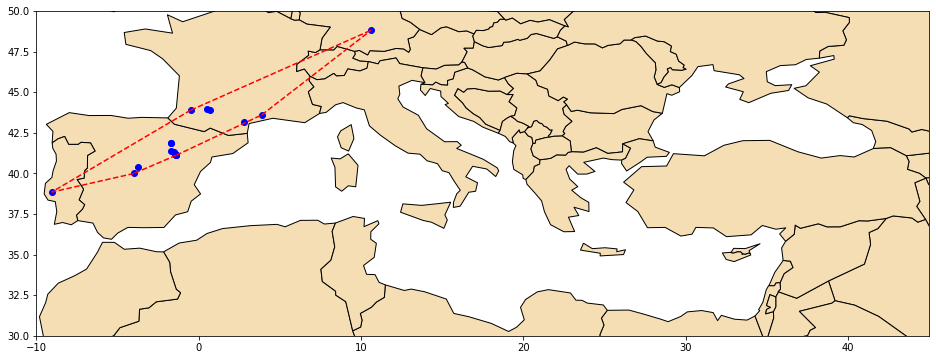

,LIDNUM,NAME,LATSTR,LONGSTR,LAT,LONG,MAX_AGE,BFA_MAX,BFA_MAX_ABS,FRAC_MAX,MIN_AGE,BFA_MIN,BFA_MIN_ABS,FRAC_MIN,CHRON,COUNTRY,STATE,COUNTY,APNUMSPM,GENERAL,LOC_SYNONYMS,MEAN_HYPSODONTY,ESTIMATE_PRECIP,ESTIMATE_TEMP,ESTIMATE_NPP,PERS_WOODY_COVER,PERS_POLLEN_AP,PERS_POLLEN_NAP,PERS_POLLEN_OTHER,SIDNUM,ORDER,FAMILY,GENUS,SPECIES,SUBCLASSORSUPERORDER,SUBORDERORSUPERFAMILY,SUBFAMILY,UNIQUE,TAXON_STATUS,ID_STATUS,ADD_INFO,SOURCE_NAME,LS_MICROWEAR,LS_MESOWEAR,LS_MESOWEAR_SCORE,LS_MW_OR_HIGH,LS_MW_OR_LOW,LS_MW_CS_SHARP,LS_MW_CS_ROUND,LS_MW_CS_BLUNT,SVLENGTH,BODYMASS,SXDIMSZE,SXDIMDIS,TSHM,TCRWNHT,HORIZODONTY,CROWNTYP,CUSP_SHAPE,CUSP_COUNT_BUCCAL,CUSP_COUNT_LINGUAL,LOPH_COUNT_LON,LOPH_COUNT_TRS,FCT_AL,FCT_OL,FCT_SF,FCT_OT,FCT_CM,MICROWEAR,MESOWEAR,MESOWEAR_SCORE,MW_OR_HIGH,MW_OR_LOW,MW_CS_SHARP,MW_CS_ROUND,MW_CS_BLUNT,DIET_1,DIET_2,DIET_3,LOCOMO1,LOCOMO2,LOCOMO3,SPCOMMENT,SYNONYMS,MEAN_AGE,TIMEUNIT,ID,HYP,LOP
1075,27274.0,Alhambra-Túneles,40 24 17 N,3 43 21 W,40.404739,-3.722606,14.2,mn6,\N,\N,12.85,mn6,\N,\N,\N,Spain,Madrid,\N,\N,\N,Túneles,1.20,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,149,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,p,herbivore,\N,\N,\N,\N,\N,\N,13.525,MN6,24.0,NaN,NaN
2080,21510.0,Armantes 7,41 21 45 N,1 43 21 W,41.362600,-1.722700,14.2,mn6,\N,\N,12.85,mn6,\N,\N,\N,Spain,Aragon,Province of Zaragoza,\N,\N,Armantes VII,\N,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,149,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,p,herbivore,\N,\N,\N,\N,\N,\N,13.525,MN6,24.0,NaN,NaN
2259,20597.0,Arroyo del Val VI,41 10 32 N,1 26 47 W,41.175600,-1.446600,14.2,mn6,\N,\N,12.85,mn6,\N,\N,Aragonian,Spain,Province de Zaragoza,\N,\N,\N,Arroyo del Val 6,1.33,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,149,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,p,herbivore,\N,\N,\N,\N,\N,\N,13.525,MN6,24.0,NaN,NaN
4973,24817.0,Borjas,41 10 9 N,1 26 40 W,41.169400,-1.444500,14.2,mn6,\N,\N,12.85,mn6,\N,\N,Upper Aragonian,Spain,Province of Zaragoza,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,149,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,p,herbivore,\N,\N,\N,\N,\N,\N,13.525,MN6,24.0,NaN,NaN
7966,20009.0,Castelnau-d'Arbieu,43 53 00 N,00 42 00 E,43.883000,0.700000,14.2,mn6,\N,\N,12.85,mn6,\N,\N,\N,France,\N,\N,50,n,\N,1.00,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,149,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,p,herbivore,\N,\N,\N,\N,\N,\N,13.525,MN6,24.0,NaN,NaN
16796,26690.0,Cerro de Almodovar 1,40 0 0 N,4 0 0 W,40.000000,-4.000000,14.2,mn6,\N,\N,12.85,mn6,\N,\N,\N,Spain,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,149,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,p,herbivore,\N,\N,\N,\N,\N,\N,13.525,MN6,24.0,NaN,NaN
32431,27448.0,La Grenatière,43 36 29 N,3 52 46 E,43.608176,3.879446,16.4,mn5,\N,\N,9.90,mn9,\N,\N,\N,France,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,149,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,p,herbivore,\N,\N,\N,\N,\N,\N,13.150,MN6,24.0,NaN,NaN
34336,21535.0,Las Planas 5B,41 11 00 N,01 28 00 W,41.183000,-1.467000,14.2,mn6,\N,\N,12.85,mn6,\N,\N,Upper Aragonian,Spain,Province of Zaragoza,\N,\N,\N,Las Planas,\N,\N,\N,\N,\N,\N,\N,\N,21064.0,Rodentia,Sciuridae,Heteroxerus,grivensis,Eutheria,\N,\N,-,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\N,\

In [60]:
species = 24
timeUnit = 'MN6'

occurrences = df[(df['TIMEUNIT']==timeUnit) & (df['ID']==species)] 
points = occurrences[['LONG','LAT']]
hull = ConvexHull(points)
fig, ax = plt.subplots(figsize=(16,8))
myMap.plot(ax=ax, color='wheat', edgecolor='black')
plt.scatter(hull.points[:,0], hull.points[:,1], c='b')
for simplex in hull.simplices:
    plt.plot(hull.points[simplex,0], hull.points[simplex,1], 'r--')
plt.xlim((-10,45))
plt.ylim((30,50))
plt.show()

display(occurrences)

# FIRST OCCURRENCES

In [54]:
# ADD INFO FOR EACH SPECIES ON THEIR OCCURRENCES IN HOTSPOTS
for timeUnit in timeUnits[1:-1]:
    # determine hotspots and hot spot species
    hotspots = localityFeatures[(localityFeatures['TIMEUNIT']==timeUnit) & \
                                (localityFeatures['SIGNIFICANCE FIRST']<0.05)]
    hotspot_species = set(df.loc[df['LIDNUM'].isin(hotspots.index),'ID'].unique())
    hotspot_species = hotspot_species.intersection(allowed_species)
    biodiversity_hotspots = localityFeatures[(localityFeatures['TIMEUNIT']==timeUnit) & \
                     (localityFeatures['SIGNIFICANCE FIRST']<0.05) & (localityFeatures['SIGNIFICANCE LAST']>0.95)]
    biodiversity_hotspot_species = set(df.loc[df['LIDNUM'].isin(biodiversity_hotspots.index),'ID'].unique())
    biodiversity_hotspot_species = biodiversity_hotspot_species.intersection(allowed_species)
    
    # determine info on first occurrences
    first_occurring_species = speciesFirstOccurrence.loc[speciesFirstOccurrence[timeUnit]==1].index
    species_with_first_occurrence_in_hotspot = hotspot_species.intersection(first_occurring_species)
    species_with_first_occurrence_in_biodiversity_hotspot = \
                biodiversity_hotspot_species.intersection(first_occurring_species)
    
    # import info to speciesLifespan dataframe
    speciesLifespan.loc[species_with_first_occurrence_in_hotspot,'FIRST OCCURRENCE IN HOTSPOT'] = 'yes'
    speciesLifespan.loc[hotspot_species,'ANY OCCURRENCE IN HOTSPOT'] = 'yes'        
    
    speciesLifespan.loc[species_with_first_occurrence_in_biodiversity_hotspot,\
                        'FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT'] = 'yes'    
    speciesLifespan.loc[biodiversity_hotspot_species,'ANY OCCURRENCE IN BIODIVERSITY HOTSPOT'] = 'yes'

speciesLifespan.loc[speciesLifespan['FIRST OCCURRENCE IN HOTSPOT'].isnull(), 'FIRST OCCURRENCE IN HOTSPOT'] = 'no'
speciesLifespan.loc[speciesLifespan['ANY OCCURRENCE IN HOTSPOT'].isnull(), 'ANY OCCURRENCE IN HOTSPOT'] = 'no'
speciesLifespan.loc[speciesLifespan['FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT'].isnull(), \
                    'FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT'] = 'no'
speciesLifespan.loc[speciesLifespan['ANY OCCURRENCE IN BIODIVERSITY HOTSPOT'].isnull(), \
                    'ANY OCCURRENCE IN BIODIVERSITY HOTSPOT'] = 'no'

speciesLifespan.loc[(speciesLifespan['FIRST OCCURRENCE IN HOTSPOT']=='no') & \
                    (speciesLifespan['ANY OCCURRENCE IN HOTSPOT']=='yes'), 'OLD OCCURRENCE (ONLY) IN HOTSPOT'] = 'yes'
speciesLifespan.loc[speciesLifespan['OLD OCCURRENCE (ONLY) IN HOTSPOT'].isnull(), \
                    'OLD OCCURRENCE (ONLY) IN HOTSPOT'] = 'no'
speciesLifespan.loc[(speciesLifespan['FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT']=='no') & \
                    (speciesLifespan['ANY OCCURRENCE IN BIODIVERSITY HOTSPOT']=='yes'), \
                    'OLD OCCURRENCE (ONLY) IN BIODIVERSITY HOTSPOT'] = 'yes'
speciesLifespan.loc[speciesLifespan['OLD OCCURRENCE (ONLY) IN BIODIVERSITY HOTSPOT'].isnull(), \
                    'OLD OCCURRENCE (ONLY) IN BIODIVERSITY HOTSPOT'] = 'no'

speciesLifespan.head()

,GENUS,SPECIES,LIFESPAN (time units),LIFESPAN (My),FIRST OCCURRENCE IN HOTSPOT,ANY OCCURRENCE IN HOTSPOT,FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT,ANY OCCURRENCE IN BIODIVERSITY HOTSPOT,OLD OCCURRENCE (ONLY) IN HOTSPOT,OLD OCCURRENCE (ONLY) IN BIODIVERSITY HOTSPOT
24,Heteroxerus,grivensis,10,15.4,no,yes,no,yes,yes,yes
53,Vasseuromys,bacchius,5,8.8,no,yes,no,no,yes,no
523,Piezodus,tomerdingensis,2,3.5,no,yes,no,no,yes,no
609,Steneofiber,eseri,10,15.4,no,yes,no,yes,yes,yes
815,Vasseuromys,autolensis,2,3.5,no,yes,no,no,yes,no


In [55]:
print('speciesRange:')
print('Average range of species that do not have a first occurrence in a hotspot: ' \
      + str(speciesRange.loc[speciesLifespan['FIRST OCCURRENCE IN HOTSPOT']=='no'].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a first occurrence in a hotspot: ' \
      + str(speciesRange.loc[speciesLifespan['FIRST OCCURRENCE IN HOTSPOT']=='yes'].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a first occurrence in a biodiversity hotspot: ' \
      + str(speciesRange.loc[speciesLifespan['FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT']=='yes']\
            .mean(axis=1).mean()) + ' km^2.')

speciesRange:
Average range of species that do not have a first occurrence in a hotspot: 159154.19195617622 km^2.
Average range of species that have a first occurrence in a hotspot: 272594.91826455836 km^2.
Average range of species that have a first occurrence in a biodiversity hotspot: 227978.62195776153 km^2.


In [56]:
print('speciesRange: singletons removed')
print('Average range of species that do not have a first occurrence in a hotspot: ' \
      + str(speciesRange.loc[(speciesLifespan['FIRST OCCURRENCE IN HOTSPOT']=='no') & \
                                     (speciesLifespan['LIFESPAN (time units)']>1)].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a first occurrence in a hotspot: ' \
      + str(speciesRange.loc[(speciesLifespan['FIRST OCCURRENCE IN HOTSPOT']=='yes') & \
                                     (speciesLifespan['LIFESPAN (time units)']>1)].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a first occurrence in a biodiversity hotspot: ' \
      + str(speciesRange.loc[(speciesLifespan['FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT']=='yes') & \
                                     (speciesLifespan['LIFESPAN (time units)']>1)].mean(axis=1).mean()) + ' km^2.')

speciesRange: singletons removed
Average range of species that do not have a first occurrence in a hotspot: 310011.12253156904 km^2.
Average range of species that have a first occurrence in a hotspot: 446079.3653240407 km^2.
Average range of species that have a first occurrence in a biodiversity hotspot: 288215.48366540484 km^2.


# LAST OCCURRENCES

In [57]:
# ADD INFO FOR EACH SPECIES ON THEIR OCCURRENCES IN HOTSPOTS
for timeUnit in timeUnits[1:-1]:
    # determine hotspots and hot spot species
    hotspots = localityFeatures[(localityFeatures['TIMEUNIT']==timeUnit) & \
                                (localityFeatures['SIGNIFICANCE LAST']<0.05)]
    hotspot_species = set(df.loc[df['LIDNUM'].isin(hotspots.index),'ID'].unique())
    hotspot_species = hotspot_species.intersection(allowed_species)
    biodiversity_hotspots = localityFeatures[(localityFeatures['TIMEUNIT']==timeUnit) & \
                     (localityFeatures['SIGNIFICANCE LAST']<0.05) & (localityFeatures['SIGNIFICANCE FIRST']>0.95)]
    biodiversity_hotspot_species = set(df.loc[df['LIDNUM'].isin(biodiversity_hotspots.index),'ID'].unique())
    biodiversity_hotspot_species = biodiversity_hotspot_species.intersection(allowed_species)
    
    # determine info on last occurrences
    last_occurring_species = speciesLastOccurrence.loc[speciesLastOccurrence[timeUnit]==1].index
    species_with_last_occurrence_in_hotspot = hotspot_species.intersection(last_occurring_species)
    species_with_last_occurrence_in_biodiversity_hotspot = \
                biodiversity_hotspot_species.intersection(last_occurring_species)
    
    # import info to speciesLifespan dataframe
    speciesLifespan.loc[species_with_last_occurrence_in_hotspot,'LAST OCCURRENCE IN HOTSPOT'] = 'yes'
    speciesLifespan.loc[species_with_last_occurrence_in_biodiversity_hotspot,\
                        'LAST OCCURRENCE IN BIODIVERSITY HOTSPOT'] = 'yes'    

speciesLifespan.loc[speciesLifespan['LAST OCCURRENCE IN HOTSPOT'].isnull(), 'LAST OCCURRENCE IN HOTSPOT'] = 'no'
speciesLifespan.loc[speciesLifespan['LAST OCCURRENCE IN BIODIVERSITY HOTSPOT'].isnull(), \
                    'LAST OCCURRENCE IN BIODIVERSITY HOTSPOT'] = 'no'

speciesLifespan.head()

,GENUS,SPECIES,LIFESPAN (time units),LIFESPAN (My),FIRST OCCURRENCE IN HOTSPOT,ANY OCCURRENCE IN HOTSPOT,FIRST OCCURRENCE IN BIODIVERSITY HOTSPOT,ANY OCCURRENCE IN BIODIVERSITY HOTSPOT,OLD OCCURRENCE (ONLY) IN HOTSPOT,OLD OCCURRENCE (ONLY) IN BIODIVERSITY HOTSPOT,LAST OCCURRENCE IN HOTSPOT,LAST OCCURRENCE IN BIODIVERSITY HOTSPOT
24,Heteroxerus,grivensis,10,15.4,no,yes,no,yes,yes,yes,no,no
53,Vasseuromys,bacchius,5,8.8,no,yes,no,no,yes,no,no,no
523,Piezodus,tomerdingensis,2,3.5,no,yes,no,no,yes,no,yes,no
609,Steneofiber,eseri,10,15.4,no,yes,no,yes,yes,yes,no,no
815,Vasseuromys,autolensis,2,3.5,no,yes,no,no,yes,no,yes,no


In [58]:
print('speciesRange:')
print('Average range of species that do not have a last occurrence in a hotspot: ' \
      + str(speciesRange.loc[speciesLifespan['LAST OCCURRENCE IN HOTSPOT']=='no'].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a last occurrence in a hotspot: ' \
      + str(speciesRange.loc[speciesLifespan['LAST OCCURRENCE IN HOTSPOT']=='yes'].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a last occurrence in a biodiversity hotspot: ' \
      + str(speciesRange.loc[speciesLifespan['LAST OCCURRENCE IN BIODIVERSITY HOTSPOT']=='yes']\
            .mean(axis=1).mean()) + ' km^2.')

speciesRange:
Average range of species that do not have a last occurrence in a hotspot: 153580.0037931385 km^2.
Average range of species that have a last occurrence in a hotspot: 291654.3500667327 km^2.
Average range of species that have a last occurrence in a biodiversity hotspot: 459795.9554902638 km^2.


In [59]:
print('speciesRange: singletons removed.')
print('Average range of species that do not have a last occurrence in a hotspot: ' \
      + str(speciesRange.loc[(speciesLifespan['LAST OCCURRENCE IN HOTSPOT']=='no') & \
                                     (speciesLifespan['LIFESPAN (time units)']>1)].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a last occurrence in a hotspot: ' \
      + str(speciesRange.loc[(speciesLifespan['LAST OCCURRENCE IN HOTSPOT']=='yes') & \
                                     (speciesLifespan['LIFESPAN (time units)']>1)].mean(axis=1).mean()) + ' km^2.')
print('Average range of species that have a last occurrence in a biodiversity hotspot: ' \
      + str(speciesRange.loc[(speciesLifespan['LAST OCCURRENCE IN BIODIVERSITY HOTSPOT']=='yes') & \
                                     (speciesLifespan['LIFESPAN (time units)']>1)].mean(axis=1).mean()) + ' km^2.')

speciesRange: singletons removed.
Average range of species that do not have a last occurrence in a hotspot: 281139.826475997 km^2.
Average range of species that have a last occurrence in a hotspot: 517275.6924535237 km^2.
Average range of species that have a last occurrence in a biodiversity hotspot: 637100.7378429236 km^2.
